# OpenET SSEBop
## Collection "Interpolate" Examples

In [42]:
import datetime
import pprint

import ee
import pandas as pd

from IPython.display import Image
import openet.ssebop as model

ee.Initialize()

In [43]:
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']

image_size = 768
landsat_cs = 30

## Input parameters

In [44]:
collections = ['LANDSAT/LC08/C01/T1_TOA']

et_reference_source = 'projects/climate-engine/cimis/daily'
et_reference_band = 'ETr_ASCE'
et_reference_factor = 1.0
et_reference_resample = 'nearest'
et_reference_date_type = 'daily'
# et_reference_source = 'IDAHO_EPSCOR/GRIDMET'
# et_reference_band = 'etr'
# et_reference_factor = 0.85
# et_reference_resample = 'nearest'
# et_reference_date_type = 'daily'

# Date range you want to aggregate ET over
# End date is inclusive (like filterDate() calls)
start_date = '2018-07-01'
end_date = '2018-08-01'

# Only keep images with an average cloud cover less than
# Cloud cover filter parameter is not being passed in (yet)
cloud_cover = 70

# Number of extra days (at start and end) to include in interpolation
interp_days = 32
# Interpolation method - currently only LINEAR is supported
interp_method = 'LINEAR'

test_xy = [-121.5265, 38.7399]
test_point = ee.Geometry.Point(test_xy)

# study_area = ee.Geometry.Rectangle(-122.00, 38.60, -121.00, 39.0)
study_area = ee.Geometry.Rectangle(
    test_xy[0] - 0.08, test_xy[1] - 0.04, 
    test_xy[0] + 0.08, test_xy[1] + 0.04)
study_region = study_area.bounds(1, 'EPSG:4326')
study_crs = 'EPSG:32610'

## Build the Landsat 8 C1 TOA Collection object

In [45]:
model_obj = model.Collection(
    collections=collections,
    et_reference_source=et_reference_source, 
    et_reference_band=et_reference_band,
    et_reference_factor=et_reference_factor,
    et_reference_resample=et_reference_resample,
    et_reference_date_type=et_reference_date_type,
    start_date=start_date,
    end_date=end_date,
    geometry=test_point,
    cloud_cover_max=70,
    # filter_args={},
)

This isn't returning the images used for interpolation.  Should it?

In [46]:
pprint.pprint(model_obj.get_image_ids())

['LANDSAT/LC08/C01/T1_TOA/LC08_044033_20180703',
 'LANDSAT/LC08/C01/T1_TOA/LC08_044033_20180719']


In [47]:
def get_region_df(info):
    """Convert the output of getRegions to a pandas dataframe"""
    col_dict = {}
    info_dict = {}
    for i, k in enumerate(info[0][4:]):
        col_dict[k] = i+4
        info_dict[k] = {}
        
    for row in info[1:]:
        date = datetime.datetime.utcfromtimestamp(row[3] / 1000.0).strftime('%Y-%m-%d')
        for k, v in col_dict.items():
            info_dict[k][date] = row[col_dict[k]]
            
    return pd.DataFrame.from_dict(info_dict)

## Interpolate Daily ET

In [48]:
daily_coll = model_obj.interpolate(
    t_interval='daily', 
    variables=['et', 'et_reference', 'et_fraction'], 
    interp_method=interp_method,
    interp_days=interp_days,
)

# # This raises an EE memory error
# daily_df = get_region_df(daily_coll.getRegion(test_point, scale=30).getInfo())
# pprint.pprint(daily_df)
# print('')
# pprint.pprint(daily_df[['et', 'et_reference']].sum())

## Interpolate Monthly ET

In [49]:
monthly_coll = model_obj.interpolate(
    t_interval='monthly', 
    variables=['et', 'et_reference', 'et_fraction'], 
    interp_method=interp_method,
    interp_days=interp_days,
)
monthly_df = get_region_df(monthly_coll.getRegion(test_point, scale=30).getInfo())
pprint.pprint(monthly_df)

                    et  et_reference  et_fraction
2018-07-01  296.987579    301.346161     0.985536


## Sum of Daily ET (for one month)

In [50]:
# image_url = ee.Image(daily_coll.select(['et']).sum())\
#     .reproject(crs=study_crs, scale=100)\
#     .getThumbURL({'min': 0.0, 'max': 300, 'palette': et_palette, 
#                   'region': study_region, 'dimensions': image_size})
# Image(image_url, embed=True, format='png')

## Monthly ET (for one month)

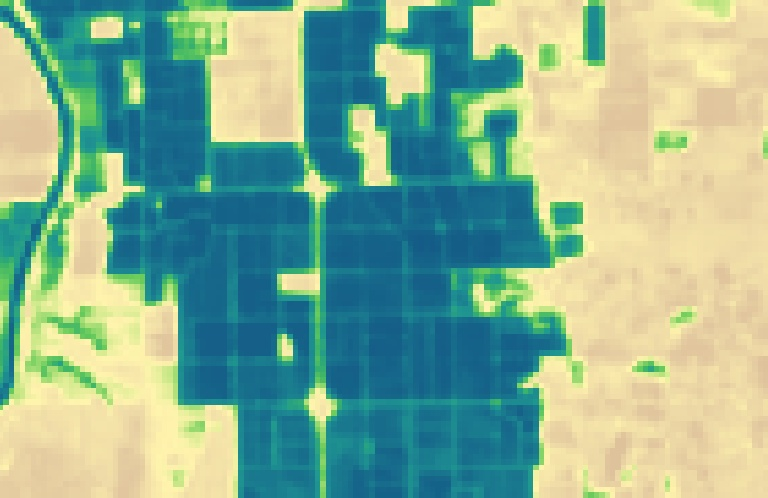

In [51]:
image_url = ee.Image(monthly_coll.select(['et']).sum())\
    .reproject(crs=study_crs, scale=100)\
    .getThumbURL({'min': 0.0, 'max': 350, 'palette': et_palette, 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

## Monthly ETr (for one month)

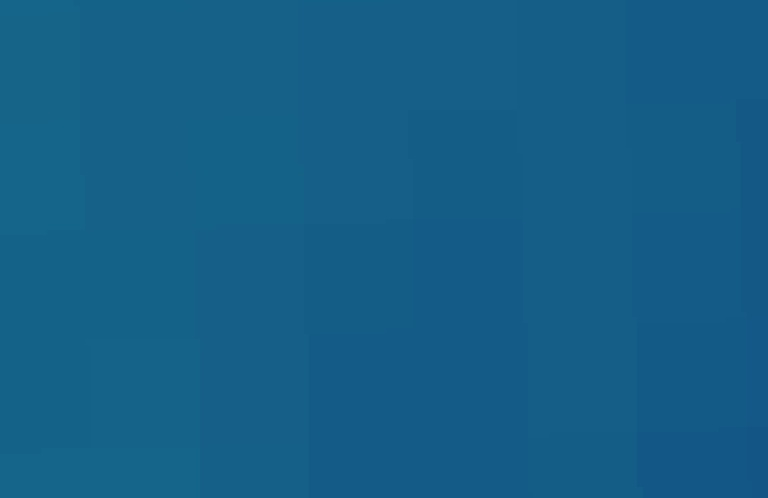

In [52]:
image_url = ee.Image(monthly_coll.select(['et_reference']).sum())\
    .reproject(crs=study_crs, scale=100)\
    .getThumbURL({'min': 0.0, 'max': 350, 'palette': et_palette, 
                  'region': study_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')